# Project Overview

##### This project involves an A/B testing analysis for the mobile game "Cookie Cats" developed by Tactile Entertainment. The primary objective of this testing is to assess the impact of moving the first gate in the game from level 30 (gate_30) to level 40 (gate_40) on user engagement, specifically measured by the number of game rounds played (sum_gamerounds).

## Data Description

##### The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

##### userid: A unique number that identifies each player.
##### version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the ##### moved gate (gate_40 - a gate at level 40).
##### sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.
##### retention_1: Did the player come back and play 1 day after installing?
##### retention_7: Did the player come back and play 7 days after installing?

##### When a player installed the game, he or she was randomly assigned to either.

## Problem Statement

##### The company may want more users for the game, and want them to purchase some stuffs in the game in order to get more revenues.

## User Journey

##### The users installed the game, and connected cookies of the same color to make a  chain. As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. 

## Hypothesis Assumption

##### · Null Hypothesis (H0): There is no significant difference in user engagement between the group encountering the first gate at level 30 (gate_30) and the group encountering it at level 40 (gate_40).
##### · Alternative Hypothesis (H1): There is a significant difference in user engagement between the two groups.

## Data Processing

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, norm
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import ttest_ind

In [62]:
data = pd.read_csv('/Users/irisyu/desktop/project/ab-test/cookie_cats.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [63]:
data.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [64]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Exploratory Data Analysis

In [65]:
data.pivot_table(index='version', values=['sum_gamerounds', 'retention_1', 'retention_7'], aggfunc='mean').reset_index()

,version,retention_1,retention_7,sum_gamerounds
0,gate_30,0.448188,0.190201,52.456264
1,gate_40,0.442283,0.182000,51.298776


In [66]:
group_A = data[data['version'] == 'gate_30']['sum_gamerounds']
group_B = data[data['version'] == 'gate_40']['sum_gamerounds']



group_A_description = data[data['version'] == 'gate_30'][['sum_gamerounds']].describe()
group_B_description = data[data['version'] == 'gate_40'][['sum_gamerounds']].describe()

pre_sda = pd.concat([group_A_description, group_B_description], axis=1)

pre_sda.columns = ['gate_30', 'gate_40']
pre_sda = pre_sda.round(2)
pre_sda

,gate_30,gate_40
count,44700.00,45489.00
mean,52.46,51.30
std,256.72,103.29
min,0.00,0.00
25%,5.00,5.00
50%,17.00,16.00
75%,50.00,52.00
max,49854.00,2640.00


Median Levels: 50% of players in both groups only reached level 16 (gate_40) or 17 (gate_30).
Upper Quartile: 75% of players reached up to level 50 (gate_30) or 52 (gate_40).

Many players stop playing before reaching gate_30 or gate_40. This may be because the game lacks sufficient appeal or challenge in the early levels, causing players to abandon the game before reaching these levels.

But this may lead to limited impact of A/B testing. Since most players fail to reach level 30 or 40, the impact of A/B testing is likely to be relatively small. Only a small number of active players actually experience different gate position settings.

Maybe the company should focus on enhancing early game levels to retain more players, as a significant number are dropping off before reaching level 30 or 40.

In [67]:
group_A_description = data[data['version'] == 'gate_30'][['sum_gamerounds']].describe(percentiles=[.99]).T.reset_index()
group_B_description = data[data['version'] == 'gate_40'][['sum_gamerounds']].describe(percentiles=[.99]).T.reset_index()
sda = pd.concat([group_A_description, group_B_description])
sda.rename(columns={'index':'group'}, inplace=True)
sda.reset_index(inplace=True)
sda.drop('index', inplace=True, axis=1)
sda.loc[0, 'group'] = 'gate_30'
sda.loc[1, 'group'] = 'gate_40'
sda

,group,count,mean,std,min,50%,99%,max
0,gate_30,44700.0,52.456264,256.716423,0.0,17.0,493.00,49854.0
1,gate_40,45489.0,51.298776,103.294416,0.0,16.0,492.12,2640.0


Since 99 percentile almost represent the dataset, we can limit the sample to 500 sum_gamerounds.

In [68]:
group_A = data[(data['version'] == 'gate_30') & (data['sum_gamerounds'] < 500)]
group_B = data[(data['version'] == 'gate_40') & (data['sum_gamerounds'] < 500)]

It seems like the dataset is not normal distribution. In order to explore more on this, I want to try several methods on it:

Visual Check: Histogram, Q-Q Plot

Shapiro-Wilk Test

Kolmogorov-Smirnov Test

### Visual Check

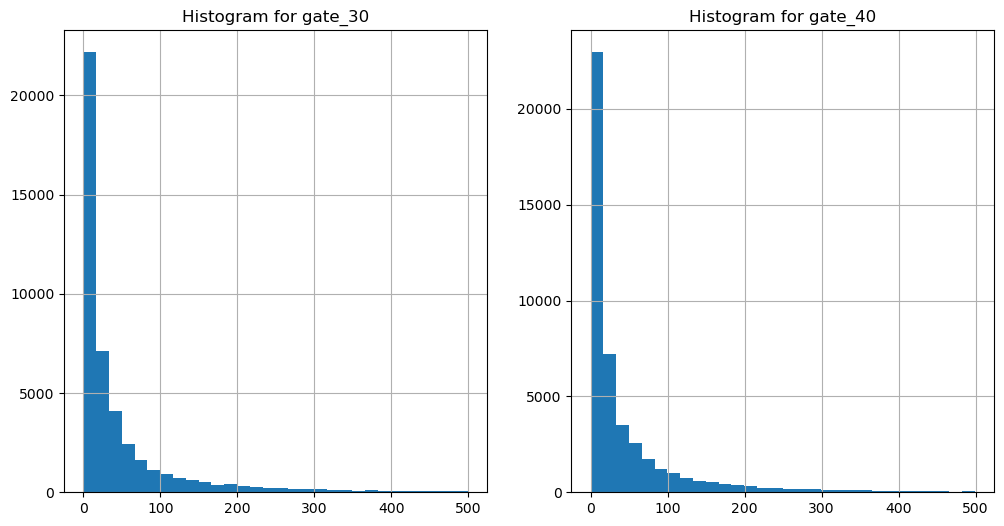

In [69]:
# Histogram 

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
group_A['sum_gamerounds'].hist(bins=30)
plt.title('Histogram for gate_30')

plt.subplot(1, 2, 2)
group_B['sum_gamerounds'].hist(bins=30)
plt.title('Histogram for gate_40')


plt.show()

### Shapiro-Wilk Test

In [70]:
shapiro_gate_30 = shapiro(group_A['sum_gamerounds'])
shapiro_gate_40 = shapiro(group_B['sum_gamerounds'])

print('Shapiro-Wilk Test for gate_30:')
print('Statistic:', shapiro_gate_30.statistic, 'p-value:', shapiro_gate_30.pvalue)

print('Shapiro-Wilk Test for gate_40:')
print('Statistic:', shapiro_gate_40.statistic, 'p-value:', shapiro_gate_40.pvalue)


Shapiro-Wilk Test for gate_30:
Statistic: 0.6179128885269165 p-value: 0.0
Shapiro-Wilk Test for gate_40:
Statistic: 0.6221011877059937 p-value: 0.0


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The p-value < alpha, which means that the dataset is not normally distributed. 

### Kolmogorov-Smirnov Test

In [71]:
ks_gate_30 = kstest(group_A['sum_gamerounds'], 'norm', args=(group_A['sum_gamerounds'].mean(), group_A['sum_gamerounds'].std()))
ks_gate_40 = kstest(group_B['sum_gamerounds'], 'norm', args=(group_B['sum_gamerounds'].mean(), group_B['sum_gamerounds'].std()))

print('Kolmogorov-Smirnov Test for gate_30:')
print('Statistic:', ks_gate_30.statistic, 'p-value:', ks_gate_30.pvalue)

print('Kolmogorov-Smirnov Test for gate_40:')
print('Statistic:', ks_gate_40.statistic, 'p-value:', ks_gate_40.pvalue)


Kolmogorov-Smirnov Test for gate_30:
Statistic: 0.26860293514869027 p-value: 0.0
Kolmogorov-Smirnov Test for gate_40:
Statistic: 0.26826014932944053 p-value: 0.0


Interpretation:



Statistic: The KS statistic quantifies the maximum distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution. Larger values indicate a greater difference.
For gate_30, the statistic is 0.419, suggesting a significant deviation from the normal distribution.
For gate_40, the statistic is 0.310, also indicating a significant deviation from the normal distribution.




p-value: The p-value indicates the probability of observing a KS statistic as extreme as, or more extreme than, the observed value under the null hypothesis (that the data follows the specified distribution).
A p-value of 0.0 (effectively less than any typical significance level such as 0.05) strongly suggests rejecting the null hypothesis.

In terms of this, we need to do a Boostrap method to execute the experiment.

### Boostrap

In [72]:
subsample = 1000
observation = 1000

sample_average_A = []
sample_average_B = []

for i in range(subsample):
    sample_A = np.random.choice(group_A['sum_gamerounds'], replace=True, size=observation)
    sample_B = np.random.choice(group_B['sum_gamerounds'], replace=True, size=observation)
    sample_average_A.append(sample_A.mean())
    sample_average_B.append(sample_B.mean())


### Visual Check for the sample

#### Histogram

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


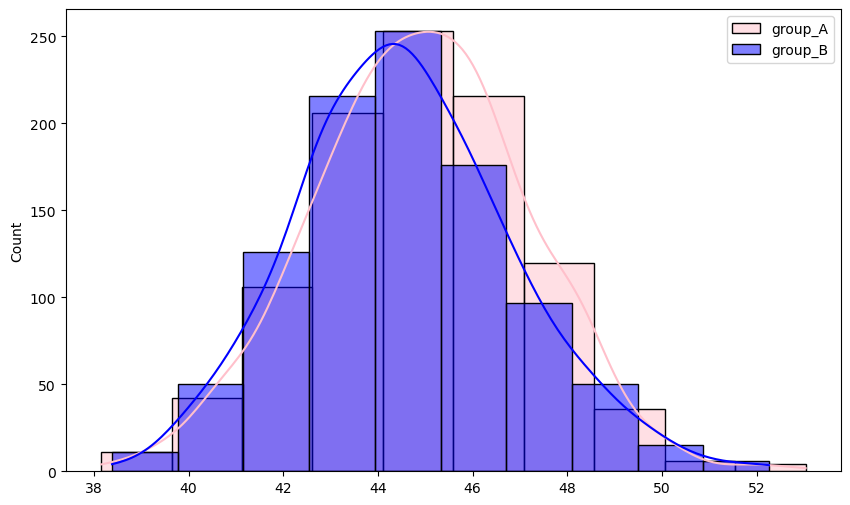

In [73]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(sample_average_A, bins=10, kde=True, color='pink', label='group_A')
sns.histplot(sample_average_B, bins=10, kde=True, color='blue', label='group_B')
plt.legend()
plt.show()

#### Q-Q Plot

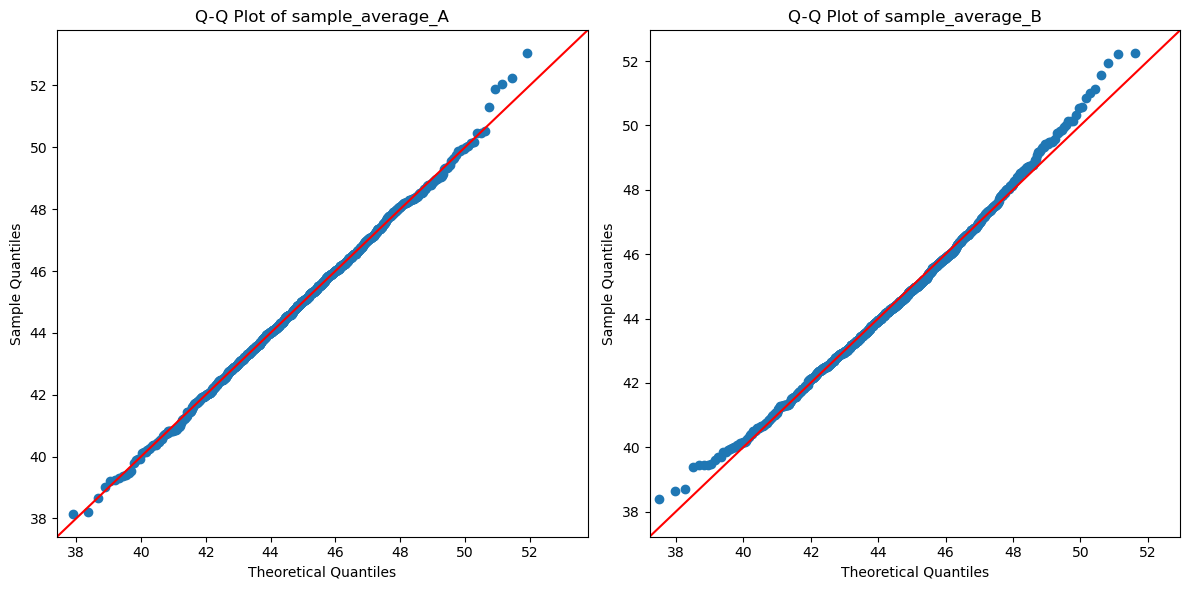

In [74]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) 
sm.qqplot(np.array(sample_average_A), loc=np.mean(sample_average_A), scale=np.std(sample_average_A), line='45', ax=plt.gca())
plt.title('Q-Q Plot of sample_average_A')

plt.subplot(1, 2, 2) 
sm.qqplot(np.array(sample_average_B), loc=np.mean(sample_average_B), scale=np.std(sample_average_B), line='45', ax=plt.gca())
plt.title('Q-Q Plot of sample_average_B')

plt.tight_layout()
plt.show()

### Shapiro-Wilk Test

In [75]:
shapiro_sample_30 = shapiro(sample_average_A)
shapiro_sample_40 = shapiro(sample_average_B)

print('Shapiro-Wilk Test for gate_30:')
print('Statistic:', shapiro_sample_30.statistic, 'p-value:', shapiro_sample_30.pvalue)

print('Shapiro-Wilk Test for gate_40:')
print('Statistic:', shapiro_sample_40.statistic, 'p-value:', shapiro_sample_40.pvalue)

Shapiro-Wilk Test for gate_30:
Statistic: 0.9988924264907837 p-value: 0.8128439784049988
Shapiro-Wilk Test for gate_40:
Statistic: 0.9948338866233826 p-value: 0.0017217325512319803


Clearly, we have the normal distribution samples.

## Hypothesis Test

In [76]:
t_statistic, p_value = ttest_ind(sample_average_A, sample_average_B, equal_var=False)

print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")


alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means of group_A and group_B.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means of group_A and group_B.")

t-statistic: 3.430904322934734
p-value: 0.0006138077324896807
Reject the null hypothesis: There is a significant difference between the means of group_A and group_B.


We performed an independent t-test to compare the means of sum_gamerounds between the two groups:

· t-statistic: 3.430904322934734
· p-value: 0.0006138077324896807
Given that the p-value is less than the significance level of 0.05, we reject the null hypothesis. Specifically, the group encountering the first gate at level 30 (gate_30) had a slightly higher mean number of game rounds compared to the group encountering the first gate at level 40 (gate_40).

## Conclusion

##### The statistical analysis shows that moving the first gate from level 30 to level 40 results in a significant but small reduction in the mean number of game rounds played. This suggests that players may be slightly less engaged when the first gate is encountered later in the game.


##### While the reduction in game rounds is statistically significant, the practical significance needs to be considered in the context of revenue. If the earlier gate placement at level 30 encourages more in-app purchases to bypass the gate, it could be beneficial for revenue. Conversely, if the frustration from encountering the gate too early leads to player drop-off, it may negatively impact user retention and long-term revenue.